In [15]:
!pip install xgboost

In [197]:
#importação das bibliotetcas usadas na predição
import os
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

#gráficos
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

In [146]:
#visualização dos dados

df= pd.read_csv ("churn_challenge_data.csv", encoding = "UTF-8", sep = ",")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 99 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Customer_ID       100000 non-null  int64  
 1   churn             100000 non-null  int64  
 2   HHstatin          62077 non-null   object 
 3   actvsubs          100000 non-null  int64  
 4   adjmou            100000 non-null  float64
 5   adjqty            100000 non-null  int64  
 6   adjrev            100000 non-null  float64
 7   adults            76981 non-null   float64
 8   area              99960 non-null   object 
 9   asl_flag          100000 non-null  object 
 10  attempt_Mean      100000 non-null  float64
 11  avg3mou           100000 non-null  int64  
 12  avg3qty           100000 non-null  int64  
 13  avg3rev           100000 non-null  int64  
 14  avg6mou           97161 non-null   float64
 15  avg6qty           97161 non-null   float64
 16  avg6rev           971

,Customer_ID,churn,HHstatin,actvsubs,adjmou,adjqty,adjrev,adults,area,asl_flag,...,threeway_Mean,totcalls,totmou,totmrc_Mean,totrev,truck,unan_dat_Mean,unan_vce_Mean,uniqsubs,vceovr_Mean
0,1000001,1,C,1,4085.00,1602,1453.44,1.0,NORTHWEST/ROCKY MOUNTAIN AREA,N,...,0.000000,1652,4228.00000,22.500,1504.62,0.0,0.0,6.333333,2,0.0
1,1000002,0,C,1,26367.00,14624,2833.88,1.0,CHICAGO AREA,N,...,0.333333,14654,26400.00000,37.425,2851.68,1.0,0.0,61.333333,1,9.1
2,1000003,1,C,1,24303.05,7888,1934.47,2.0,GREAT LAKES AREA,N,...,0.000000,7903,24385.05333,16.990,2155.91,0.0,0.0,2.666667,1,0.0
3,1000004,0,C,1,3035.00,1479,1941.81,4.0,CHICAGO AREA,N,...,0.000000,1502,3065.00000,38.000,2000.90,0.0,0.0,0.000000,1,0.0
4,1000005,0,C,1,13965.00,4452,2166.48,1.0,NEW ENGLAND AREA,N,...,0.000000,4485,14028.00000,71.980,2181.12,0.0,0.0,77.000000,1,0.0


In [18]:
df.duplicated().sum()

0

In [19]:
df.isna().sum()

Customer_ID          0
churn                0
HHstatin         37923
actvsubs             0
adjmou               0
                 ...  
truck             1732
unan_dat_Mean        0
unan_vce_Mean        0
uniqsubs             0
vceovr_Mean        357
Length: 99, dtype: int64

<AxesSubplot:xlabel='churn', ylabel='count'>

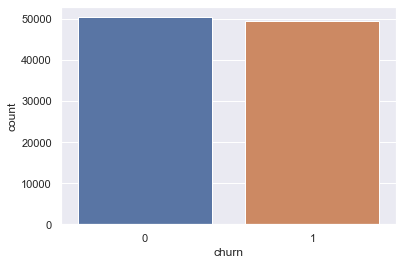

In [20]:
#Verificando taxas de Churn

df['churn'].value_counts()
sns.countplot(df['churn'])

<AxesSubplot:xlabel='prizm_social_one', ylabel='count'>

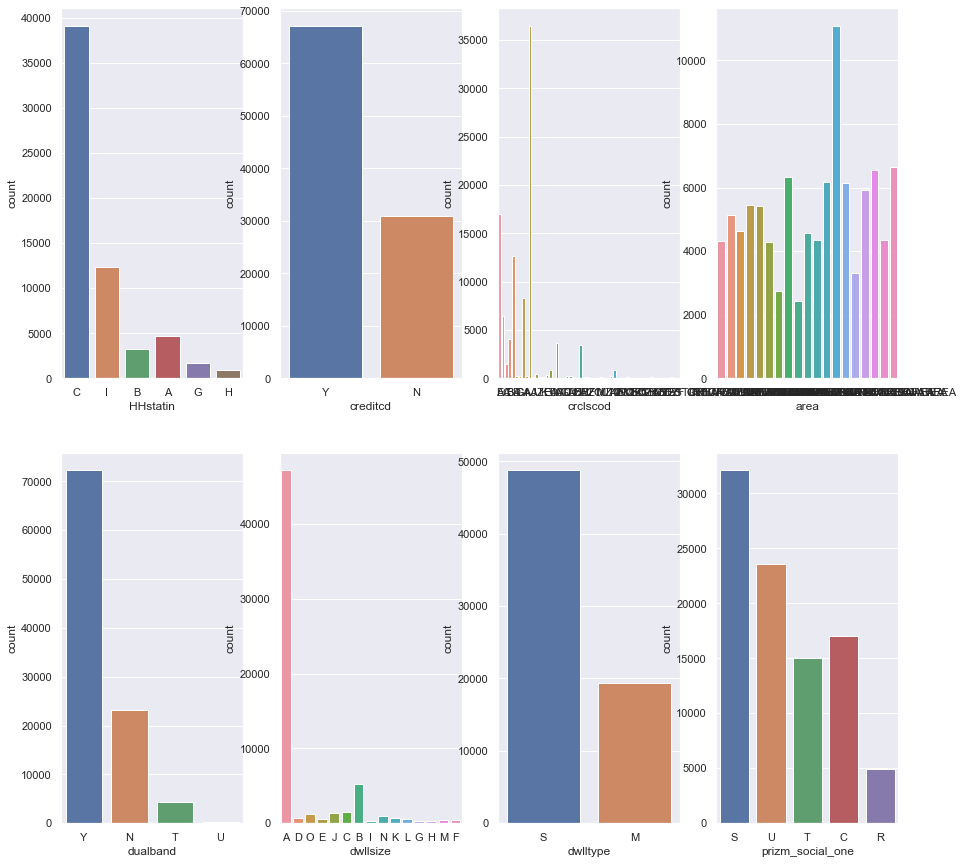

In [21]:
#visualização de variavéis

f, ax = plt.subplots(2,4, figsize=(15,15))

sns.countplot(df['HHstatin'], ax=ax[0,0])
sns.countplot(df['creditcd'], ax=ax[0,1])
sns.countplot(df['crclscod'], ax=ax[0,2])
sns.countplot(df['area'], ax=ax[0,3])
sns.countplot(df['dualband'], ax=ax[1,0])
sns.countplot(df['dwllsize'], ax=ax[1,1])
sns.countplot(df['dwlltype'], ax=ax[1,2])
sns.countplot(df['prizm_social_one'], ax=ax[1,3])


In [94]:
#Correlação de todas as vairáveis

df.corr()

,Customer_ID,churn,actvsubs,adjmou,adjqty,adjrev,adults,attempt_Mean,avg3mou,avg3qty,...,threeway_Mean,totcalls,totmou,totmrc_Mean,totrev,truck,unan_dat_Mean,unan_vce_Mean,uniqsubs,vceovr_Mean
Customer_ID,1.000000,-0.042764,-0.029977,-0.276216,-0.297841,-0.478197,-0.012623,0.072852,0.096099,0.041904,...,0.059226,-0.297798,-0.275945,0.060932,-0.468064,-0.099237,0.019113,0.090069,-0.014418,0.031738
churn,-0.042764,1.000000,0.019686,-0.017532,-0.016259,-0.002900,-0.007968,-0.048533,-0.049546,-0.043883,...,-0.030657,-0.015780,-0.016949,-0.068558,-0.003017,-0.004097,-0.004727,-0.035560,0.039882,0.024240
actvsubs,-0.029977,0.019686,1.000000,-0.017946,0.007781,-0.003066,0.074733,-0.046474,-0.058065,-0.026212,...,-0.023159,0.009558,-0.016039,-0.060243,-0.002104,0.067156,-0.006427,-0.041239,0.774229,-0.022268
adjmou,-0.276216,-0.017532,-0.017946,1.000000,0.925759,0.835433,-0.016810,0.573811,0.673897,0.660639,...,0.157981,0.925415,0.999747,0.477878,0.836831,-0.015695,0.024827,0.426040,0.004428,0.285282
adjqty,-0.297841,-0.016259,0.007781,0.925759,1.000000,0.771261,0.005642,0.554346,0.550206,0.681355,...,0.138643,0.999798,0.925616,0.393521,0.771464,0.003004,0.019697,0.417155,0.020395,0.234590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
truck,-0.099237,-0.004097,0.067156,-0.015695,0.003004,0.006306,0.260806,-0.045315,-0.055779,-0.033497,...,-0.047923,0.002668,-0.016127,-0.035703,0.004698,1.000000,-0.000725,-0.035852,0.039461,-0.029295
unan_dat_Mean,0.019113,-0.004727,-0.006427,0.024827,0.019697,0.014618,0.000251,0.065626,0.058070,0.050363,...,0.009911,0.019731,0.024911,0.041625,0.015676,-0.000725,1.000000,0.040617,-0.004498,0.030650
unan_vce_Mean,0.090069,-0.035560,-0.041239,0.426040,0.417155,0.255430,-0.002707,0.859078,0.644434,0.697518,...,0.306248,0.417296,0.426211,0.358530,0.258813,-0.035852,0.040617,1.000000,-0.018772,0.351720
uniqsubs,-0.014418,0.039882,0.774229,0.004428,0.020395,0.008911,0.059803,-0.020571,-0.024451,-0.005591,...,-0.014284,0.022994,0.007589,-0.025429,0.011241,0.039461,-0.004498,-0.018772,1.000000,-0.008519


<AxesSubplot:>

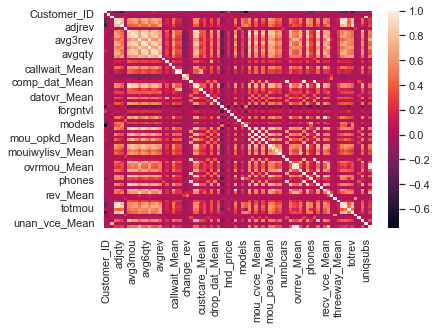

In [95]:
#Mapa de calor

sns.heatmap(df.corr())

In [184]:
df.describe()

,churn,actvsubs,adjmou,adjqty,adjrev,adults,attempt_Mean,avg3mou,avg3qty,avg3rev,...,threeway_Mean,totcalls,totmou,totmrc_Mean,totrev,truck,unan_dat_Mean,unan_vce_Mean,uniqsubs,vceovr_Mean
count,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,...,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000,26705.000000
mean,0.468526,1.454934,7143.408893,2736.436622,959.786522,2.724658,127.935568,454.450440,161.188092,55.782325,...,0.218349,2773.930762,7234.370718,45.003869,1029.384280,0.346227,0.027361,23.760632,1.618985,11.426203
std,0.499018,0.684558,8823.759014,3864.058391,844.479161,1.315672,141.714830,480.868679,175.548668,42.833614,...,0.836215,3896.904754,8895.572487,23.808488,857.224212,0.475776,0.364574,33.041362,0.892813,26.936827
min,0.000000,0.000000,0.000000,0.000000,23.750000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,-1.422500,23.750000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1.000000,2256.000000,789.000000,447.850000,2.000000,34.000000,133.000000,49.000000,32.000000,...,0.000000,805.000000,2291.000000,30.000000,513.070000,0.000000,0.000000,4.333333,1.000000,0.000000
50%,0.000000,1.000000,4606.000000,1651.000000,733.070000,2.000000,88.000000,308.000000,109.000000,44.000000,...,0.000000,1676.000000,4687.000000,42.490000,799.160000,0.000000,0.000000,13.666667,1.000000,0.000000
75%,1.000000,2.000000,8918.000000,3288.000000,1188.200000,3.000000,174.000000,606.000000,211.000000,66.000000,...,0.000000,3335.000000,9023.000000,58.000000,1264.580000,1.000000,0.000000,30.666667,2.000000,10.937500
max,1.000000,9.000000,174383.380000,79930.000000,14906.570000,6.000000,2181.333333,6046.000000,3261.000000,835.000000,...,38.666667,80295.000000,174467.380000,349.572500,15023.950000,1.000000,41.333333,814.333333,13.000000,528.600000


In [148]:
# Retirando colunas
df.drop(['Customer_ID'], axis=1, inplace = True)
df = df.dropna(how = "any", axis=0)

df.drop(['area'], axis=1, inplace = True)
df.drop(['asl_flag'], axis=1, inplace = True)
df.drop(['crclscod'], axis=1, inplace = True)
df.drop(['creditcd'], axis=1, inplace = True)
df.drop(['dualband'], axis=1, inplace = True)
df.drop(['dwllsize'], axis=1, inplace = True)
df.drop(['dwlltype'], axis=1, inplace = True)
df.drop(['ethnic'], axis=1, inplace = True)
df.drop(['hnd_webcap'], axis=1, inplace = True)
df.drop(['infobase'], axis=1, inplace = True)
df.drop(['kid0_2'], axis=1, inplace = True)
df.drop(['kid11_15'], axis=1, inplace = True)
df.drop(['kid16_17'], axis=1, inplace = True)
df.drop(['kid3_5'], axis=1, inplace = True)
df.drop(['kid6_10'], axis=1, inplace = True)
df.drop(['marital'], axis=1, inplace = True)
df.drop(['new_cell'], axis=1, inplace = True)
df.drop(['ownrent'], axis=1, inplace = True)
df.drop(['prizm_social_one'], axis=1, inplace = True)
df.drop(['refurb_new'], axis=1, inplace = True)
df.drop(['HHstatin'], axis=1, inplace = True)



In [149]:
df_onehot=pd.get_dummies(df)

df_onehot.head()

,churn,actvsubs,adjmou,adjqty,adjrev,adults,attempt_Mean,avg3mou,avg3qty,avg3rev,...,threeway_Mean,totcalls,totmou,totmrc_Mean,totrev,truck,unan_dat_Mean,unan_vce_Mean,uniqsubs,vceovr_Mean
0,1,1,4085.00,1602,1453.44,1.0,52.333333,272,116,30,...,0.000000,1652,4228.00000,22.50,1504.62,0.0,0.0,6.333333,2,0.000
4,0,1,13965.00,4452,2166.48,1.0,222.333333,558,191,55,...,0.000000,4485,14028.00000,71.98,2181.12,0.0,0.0,77.000000,1,0.000
9,0,2,976.00,377,1457.84,2.0,6.666667,6,3,30,...,0.000000,391,994.00000,29.99,1458.42,0.0,0.0,2.333333,2,0.000
14,0,1,69104.08,33139,6572.70,3.0,344.666667,2038,637,248,...,0.000000,33184,69161.08333,84.99,6616.72,0.0,0.0,43.666667,5,99.800
16,0,1,11316.00,4067,1722.98,2.0,138.333333,446,193,63,...,0.333333,4078,11330.00000,59.98,1739.43,0.0,0.0,17.333333,1,1.725


In [190]:
#separando teste e treino

X = df_onehot.drop(['churn'],axis=1)
y = df_onehot['churn'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)

In [191]:
#criando modelo
model = LogisticRegression()
model.fit(X_train, y_train)



#aplicando modelo

y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual':y_test.flatten(),
                                 'Prediction':y_predict.flatten()})


print(actual_vs_predict.sample(20))


      Actual  Prediction
2921       0           0
5304       0           0
2582       0           0
3490       1           1
2818       0           1
3647       0           0
9          1           0
5276       0           0
5255       1           0
1578       1           1
4826       0           0
838        1           0
2647       0           0
3014       1           0
1688       0           0
995        1           0
1048       0           1
4939       0           0
2142       1           1
1178       0           0


ROC AUC: 56.34 %


Text(0, 0.5, 'True Positive Label')

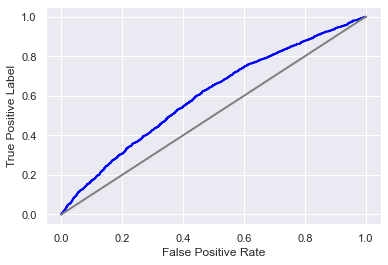

In [192]:
#AVALIAÇÃO DO MODELO

print('ROC AUC: %.2f' % (roc_auc_score(y_test,y_predict)*100),'%')

#VISUALIZAÇÃO

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot (fpr, tpr, lw=2, color='blue')
plt.plot([0,1],[0,1], lw=2, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Label')


In [195]:
#Conferindo com GBM

model= GradientBoostingClassifier (learning_rate=0.1, max_depth=2, n_estimators=200, max_features=8, random_state=42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual':y_test.flatten(),
                                 'Prediction':y_predict.flatten()})


print(actual_vs_predict.sample(20))

      Actual  Prediction
2214       0           0
3674       1           0
1185       1           0
4915       0           0
2120       0           1
4392       1           1
4586       0           0
2722       0           1
5091       0           1
3676       0           1
3931       1           1
3358       0           0
2079       0           1
1232       1           1
449        1           1
307        1           1
1128       1           1
1996       1           1
4637       0           1
4862       0           0


ROC AUC: 62.21 %


Text(0, 0.5, 'True Positive Label')

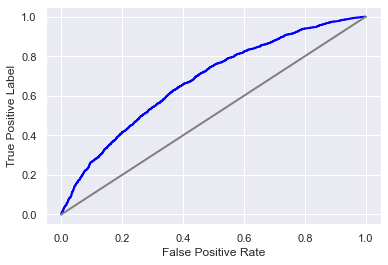

In [154]:
#AVALIAÇÃO DO MODELO

print('ROC AUC: %.2f' % (roc_auc_score(y_test,y_predict)*100),'%')

#VISUALIZAÇÃO

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot (fpr, tpr, lw=2, color='blue')
plt.plot([0,1],[0,1], lw=2, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Label')

In [198]:
model = XGBClassifier (max_depth=2, learning_rat=0.1, n_estimators=200)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
actual_vs_predict = pd.DataFrame({'Actual':y_test.flatten(),
                                 'Prediction':y_predict.flatten()})


print(actual_vs_predict.sample(20))

[19:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "learning_rat" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:49:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:49:21] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prun

[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned nodes, max_depth=2
[19:49:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 6 extra nodes, 0 pruned

ROC AUC: 62.42 %


Text(0, 0.5, 'True Positive Label')

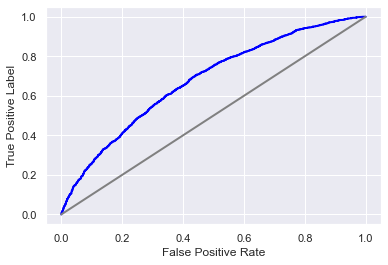

In [199]:
#AVALIAÇÃO DO MODELO

print('ROC AUC: %.2f' % (roc_auc_score(y_test,y_predict)*100),'%')

#VISUALIZAÇÃO

y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot (fpr, tpr, lw=2, color='blue')
plt.plot([0,1],[0,1], lw=2, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Label')

In [200]:
weights = pd.Series(model.coef_[0], index=X.columns.values)
print (weights.sort_values(ascending=False)[:10].plot(kind='barh'))

AttributeError: Coefficients are not defined for Booster type None

In [189]:
weights = pd.Series(model.coef_[0], index=X.columns.values)
print(weights.sort_values(ascending=False)[-10:].plot(kind-'barh'))

AttributeError: Coefficients are not defined for Booster type None